![CEE Masthead](http://kyrill.ias.sdsmt.edu/wjc/eduresources/AES_519_Masthead.png)

# "Wanna cause some chaos?" (Diff-e-Fu Edition) [Starter Pack]
# Integration in Python with SciPy.

## Introduction
This a Python program is an example of a "Lorenz Model" in Chaos Modeling


This is also a good example of 
*  Scripting in Python
*  Solving Differential Equations in Python
*  Illustrating  how to code coupled systems of equations.

One of classic problems in theoretical meteorology is the presentation of "Chaos."

Put simply Chaos is an intrisic impredictability that can emerge in non-linear prognostic equations.  

It orignated with [Edward Lorenz classic 1993 paper](https://doi.org/10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2) where he saw non-periodic oscillation in non-linear deterministic systems whose predictabiity breaks down after a given period for small variations in the system's initial conditons.

While the schematic for such a system can be presented systems modeling framework (we do this in AES 615) with the figure below...

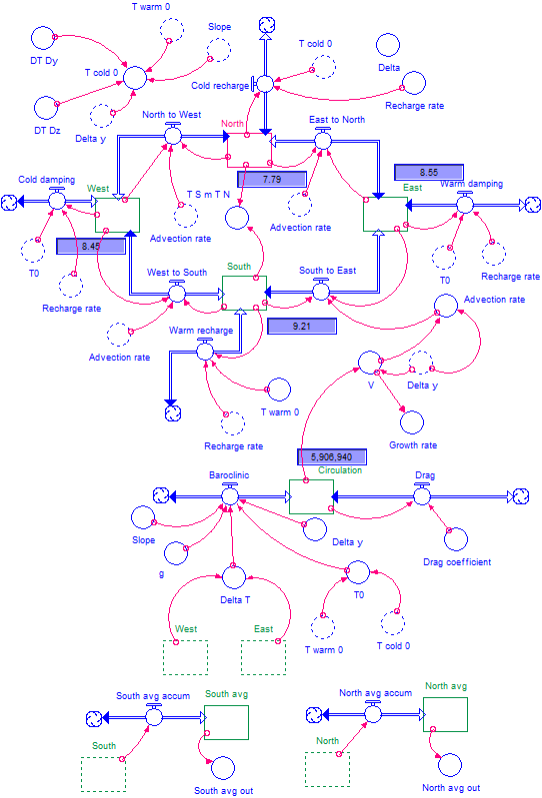

The relevant behavior can be presented as a more digestable trio of equations.\\

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma \left ( y - x  \right )  \\ 
\frac{dy}{dt} &= x \left ( \rho - z \right ) - y\\
\frac{dz}{dt} &= xy-\beta z
\end{aligned}
$$ 

where for good results, 

$$
\begin{aligned}
\sigma  &= 10  \\ 
\rho  &= 40\\
\beta  &= 8/3
\end{aligned}
$$


There are a few ways to solve this system with our current skill set.  With Diff-E-Fu, you would normally use Euler's Method or a Runge-Kutta approach.  But with python we ahve some other tricks.

So let's try them out.



## Libraries

Let's start with the libraries

* [NumPy](https://docs.scipy.org/doc/NumPy/reference/routines.math.html) for some basic math functions
* [SciPy](https://docs.scipy.org/doc/scipy/reference/integrate.html) for ODE solving using the integration sublibrary
* [SymPy](https://www.sympy.org/en/index.html) for symbolic solutions
* [Matplotlib](https://matplotlib.org) Our go-to-package for plotting
* [mpl_toolkits](https://matplotlib.org/stable/api/toolkits/mplot3d.html?highlight=mpl_toolkits) Extentions that also include capacity for 3D plots.


In [1]:
################################################
#
# Libraries
#

import numpy                as np
import scipy                as sci
import scipy.integrate      as sciint
import sympy                as sym
import matplotlib.pyplot    as plt
import mpl_toolkits.mplot3d as mplot3d

#
################################################

Coding our equations.  We can do this rather easily by defining our functions.  Here we can define them together.

We will bundle our $x$, $y$, and $z$ into a single vector, $\vec{x}$.  You can then return the three equations as a list. Also up front before our prognistic variable is the variable overwhich the integration will occur.  For us, this is time, $t$. 

In [2]:
################################################
#
# Our Lorenz Equations
#

sigma = 10.
rho   = 40.
beta  = 8./3.

def lorenz(t, X):
    
    x = X[0]
    y = X[1]
    z = X[2]
    
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y 
    dzdt = x * y - beta * z
    
    return [dxdt, dydt, dzdt]
    
#
################################################

# Getting the "roots" (or "critical points") of our system

We explored solving "root" equations in our previous sessions.

Sympy also has a solver routine, [sympy.solve()](https://docs.sympy.org/latest/modules/solvers/solvers.html).  In the case below we have three solutions where our values of $x$, $y$, and $z$ do not change with time.  In Systems Modeling we call them "critical points" or "equilibrium points."  


In [3]:
################################################
#
# Our Lorenz Equations
#
display(lorenz(0, [1,1,1]))


#
################################################

[0.0, 38.0, -1.6666666666666665]

# Solving the Equations Dynamically

Getitng the points where our system doesn't move, isn't exactly the whole story of dynamic models.  Part of the fun is watching them evolve over time.  

To do this we will want to integrate over time.  Two common ways to do this is with Euler's Method or one of the Runge-Kutta methods. 

Euler's method is the easiest to conceptualize.

Here is the basic math of any generic prognostic (time-dependant) function.  In this example we are only using one prognostic variable...
1. Take a differential equations that's a function of time.  That $f_x(x)$ function represents all the forcings that are being inflicted on our mystery value *x* that change its value over time.
$$\frac{dx}{dt}=f(x)$$
2. Whistle in the dark through your Calc 1 class and hope that $f_x(x)$ doesn't change much over a *small* discrete change of your independant integrating value (for us that's time), a.k.a., $\Delta t$
$$\frac{\Delta x}{\Delta t}=f(x)$$
3. Let's now treat time like a numberline with distinct intervals of space one $\Delta t$ with our understanding of what's going on only resolvable at those discrete points on the hopscotch board that is now our modeled universe. To move forward we base our change on $x$ on our jump to the current time-step for which we're calculating, $t_{\tau}$, on our values that we just solved on our previous timestep, $t_{\tau-1}$.  (Hence it's important to chose timesteps where our valus of x don't change MUCH as we move in our steps forward in time.  This often means small values of $\Delta t$.)

![Time Numberline](http://kyrill.ias.sdsmt.edu/wjc/eduresources/Time_Tau_Numberline_Bounce.png)

$$\begin{aligned}
\frac{\Delta x}{\Delta t}=\frac{x_{\tau}-x_{\tau-1}}{\Delta t=t_{\tau}-t_{\tau-1}}&=f_x(x_{\tau-1})\\
\frac{x_{\tau}-x_{\tau-1}}{\Delta t}&=f_x(x_{\tau-1})
\end{aligned}$$

4. And from there it's just a little Algebra-Fu™️ to solve for the value of x on our landing point (a.k.a., $x_{\tau}$)

$$\begin{aligned}
\frac{x_{\tau}-x_{\tau-1}}{\Delta t}&=f_x(x_{\tau-1}) \\  
x_{\tau}-x_{\tau-1}&=f_x(x_{\tau-1})\Delta t \\
x_{\tau} &= x_{\tau-1}+f_x(x_{\tau-1})\Delta t 
\end{aligned}$$


## Drafting our Prognostic and Diagnostic Equations

In this scenario we are going to show off SciPy's integrating features.  Most of them will fit into the following setup.  

We will need a single function that contains all of our prognostic equations, $\frac{dx}{dt}$, $\frac{dy}{dt}$, and $\frac{dz}{dt}$.  We already have them from above.

## Solve that system! 

### scipy.integrate.solve_ivp

To attack this, we will use one of scipy's go to Diff-E-Fu resources: [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) which is designed for initial value problems.  


The default solver for this function is a fourth-order Runge-Kutta.  (We've included the specific line that would call this below, anyway.)

Here is what you need for this at minimum

1. an callable function that includes the basic functions.  The arguments can be as follows:
  1.  the first value needs to be the single scalar for the derivative in the function(s).  For us, that's time.
  2.  a 1-D vector or scalar of there's just one derivative containing the initial conditions for the function(s)
2. a two-element list of your start and end points for the duration of your solution range (for this case it will be for your valid time range).
3. list of your initial conditions.

There are fancier things you can do where you can use paramters as an argument, such as change our values of $\rho$, $\sigma$, and $\beta$ or specify an explicit time step but right now we are going for simplicity in the scarier function calls. 


In [6]:
################################################
#
# Use the solve_ivp function
#

TimePeriod = 50 

Y = sciint.solve_ivp(fun          = lorenz,          # Function(t, F(t)) 
                     t_span       = [0, TimePeriod], # start and end times
                     y0           = [1,1,1],         # initial conditons, Fo
                     method       = "RK45",          # method (defaults to RK45)
                     dense_output = True)            # create a "continuous" solution

#
################################################

The output for the above function is an object with a number of return variables that can be accessed from your return value (for the above, that's the Y).  

We want the contents of the "sol" object which contains what we need to access the results of the solution.

"sol" requires an argument (just like a function).  So if we want a time series, we throw in our array.  If we want any single time value, we can enter that time as well.

If the input is a vector of time values in our case, it will be a 2-d vector so that the first element is the time dimension, and the second dimension are your the solution to your input equations.  For us that's $x(t)$, $y(t)$, & $z(t)$.

To get that final array of output the call for us us Y.sol(times).T

Let's take a peak at it.

In [7]:
################################################
#
# Peaking at Y()
#

display(Y)

#
# Peaking at Y.sol()
#
# Let's just see what happens over our time period days with a delta-t of one day
#

Ytime = Y.t

print("Ytime = ",Ytime)
print(" " )


display(Y.sol(Ytime))
print(" ")
print("Ysol")
print(" ")

display(Y.sol(Ytime).T[:,0])
#
################################################

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 5696
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x17962c550>
   status: 0
  success: True
        t: array([0.00000000e+00, 3.39557531e-02, 7.99684393e-02, 1.40996005e-01,
       2.17645659e-01, 2.64174417e-01, 3.10703175e-01, 3.46659624e-01,
       3.80660939e-01, 4.26362966e-01, 4.83806941e-01, 5.54456451e-01,
       6.30940098e-01, 7.25654252e-01, 8.14275790e-01, 9.32137314e-01,
       1.02645377e+00, 1.12077022e+00, 1.21219333e+00, 1.29623951e+00,
       1.39133423e+00, 1.50462697e+00, 1.58834816e+00, 1.67206936e+00,
       1.74632942e+00, 1.82026937e+00, 1.90105853e+00, 2.01278291e+00,
       2.11488069e+00, 2.19132310e+00, 2.26586731e+00, 2.32824260e+00,
       2.39061789e+00, 2.46597798e+00, 2.54849380e+00, 2.63488306e+00,
       2.71748604e+00, 2.78470078e+00, 2.85122739e+00, 2.89976021e+00,
       2.94829303e+00, 3.01529676e+00, 3.06833433e+

Ytime =  [0.00000000e+00 3.39557531e-02 7.99684393e-02 1.40996005e-01
 2.17645659e-01 2.64174417e-01 3.10703175e-01 3.46659624e-01
 3.80660939e-01 4.26362966e-01 4.83806941e-01 5.54456451e-01
 6.30940098e-01 7.25654252e-01 8.14275790e-01 9.32137314e-01
 1.02645377e+00 1.12077022e+00 1.21219333e+00 1.29623951e+00
 1.39133423e+00 1.50462697e+00 1.58834816e+00 1.67206936e+00
 1.74632942e+00 1.82026937e+00 1.90105853e+00 2.01278291e+00
 2.11488069e+00 2.19132310e+00 2.26586731e+00 2.32824260e+00
 2.39061789e+00 2.46597798e+00 2.54849380e+00 2.63488306e+00
 2.71748604e+00 2.78470078e+00 2.85122739e+00 2.89976021e+00
 2.94829303e+00 3.01529676e+00 3.06833433e+00 3.12137190e+00
 3.17371578e+00 3.23897634e+00 3.31842048e+00 3.41414439e+00
 3.47615996e+00 3.53113799e+00 3.58550314e+00 3.63750880e+00
 3.69010967e+00 3.75880525e+00 3.82700632e+00 3.90299385e+00
 3.99080943e+00 4.07862501e+00 4.15406934e+00 4.22879247e+00
 4.30853673e+00 4.40926243e+00 4.50998812e+00 4.58655120e+00
 4.66266877e+00

array([[ 1.        ,  1.20132363,  2.11591931, ..., 19.64692672,
        17.55415338, 14.42094567],
       [ 1.        ,  2.35871368,  5.04725166, ..., 24.3607754 ,
         6.01481974, -0.62658099],
       [ 1.        ,  0.97223356,  1.11870056, ..., 49.83890879,
        58.79416422, 56.20383001]])

 
Ysol
 


array([ 1.00000000e+00,  1.20132363e+00,  2.11591931e+00,  5.07772161e+00,
        1.45834100e+01,  2.30972983e+01,  2.43932384e+01,  1.69395151e+01,
        7.84115705e+00, -1.66773888e+00, -8.28581758e+00, -1.09347257e+01,
       -9.82306329e+00, -7.44161767e+00, -7.06235984e+00, -9.85024343e+00,
       -1.30850729e+01, -1.25333548e+01, -8.67460485e+00, -6.41761738e+00,
       -6.80676237e+00, -1.08242888e+01, -1.41134717e+01, -1.28469338e+01,
       -8.77844347e+00, -5.83553594e+00, -5.12106650e+00, -7.88471825e+00,
       -1.35446328e+01, -1.53658870e+01, -1.13182330e+01, -6.91900357e+00,
       -4.23801034e+00, -3.31348347e+00, -4.40103573e+00, -8.06220063e+00,
       -1.43015305e+01, -1.73161931e+01, -1.31256389e+01, -8.07590066e+00,
       -4.12127517e+00, -1.14899917e+00, -9.35142712e-02,  4.84145822e-01,
        9.61048974e-01,  1.81507377e+00,  4.03592541e+00,  1.09268376e+01,
        1.81475299e+01,  2.01624064e+01,  1.35721158e+01,  5.42147153e+00,
       -1.47866188e-01, -

## Exploring the Results
Let's Plot it!  Here we are going to pull each value in sol.T so we can specifically customize each color.

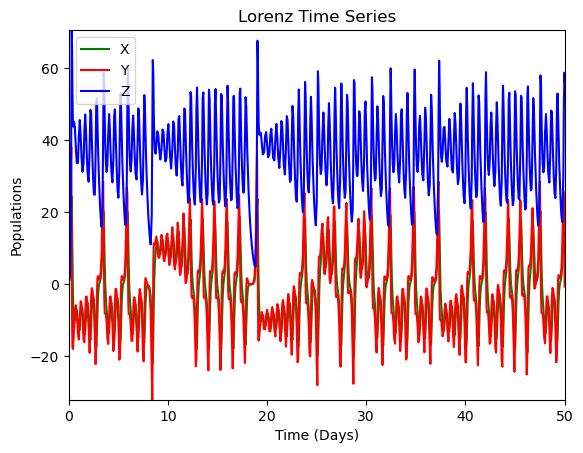

In [8]:
################################################
#
# Plot Results
#

Time = Y.t

plt.plot(Time, Y.sol(Time).T[:,0], "g", # X
         Time, Y.sol(Time).T[:,1], "r", # Y
         Time, Y.sol(Time).T[:,2], "b") # Z

plt.title("Lorenz Time Series")

plt.xlim(0, TimePeriod)

plt.ylim(np.min(Y.sol(Time).T[:,:]), 
         np.max(Y.sol(Time).T[:,:]))
plt.xlabel('Time (Days)')
plt.ylabel("Populations")
plt.legend(["X", 
            "Y",
            "Z"])
plt.show()


#
################################################


Typically when we look at the Lorenz system as meteororlogists and climate folk we really want to see a plot like the one above.. (but with one additon we'll add later).  But for the "civilians" we tend to present them in a more dramatic fashion.  

try plotting your $x$ vs $y$, or other expression of our prognostic variables

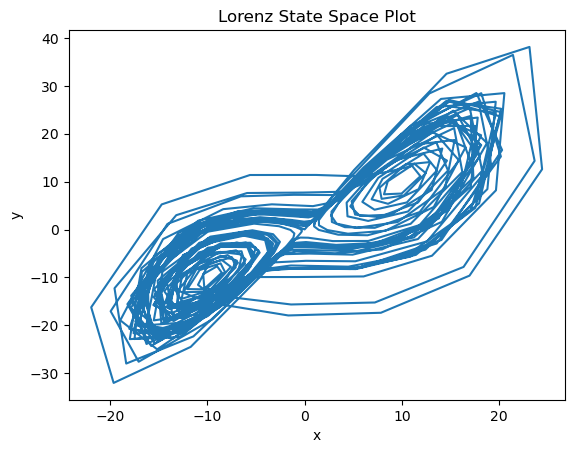

In [9]:
################################################
#
# Plot Results
#

#
# State Space Plots
#

plt.plot(Y.sol(Time).T[:,0], # X
         Y.sol(Time).T[:,1]) # Y

plt.title("Lorenz State Space Plot")

plt.xlabel('x')
plt.ylabel("y")

plt.show()


#
################################################

Well THAT wasn't what we wanted it to be.  This represents a classic lorenz cuvrve but the output is done at too course an interval.

If we want to have a little more control, can explicity ask for an output time step.

In [10]:
################################################
#
# Use the solve_ivp function
#

TimePeriod = 50 

Time_Value = np.arange(0.0,TimePeriod, 0.01)

Y = sciint.solve_ivp(fun          = lorenz,          # Function(t, F(t)) 
                     t_span       = [0, TimePeriod], # start and end times
                     y0           = [1,1,1],         # initial conditons, Fo
                     method       = "RK45",          # method (defaults to RK45)
                     dense_output = True,            # create a "continuous" solution
                     t_eval       = Time_Value)      # use an explicit time step. 

#
################################################

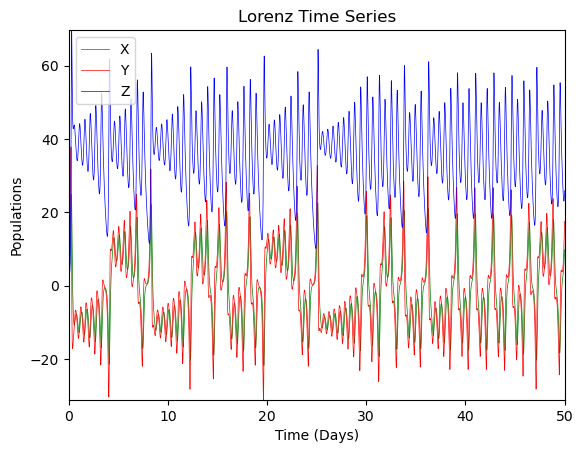

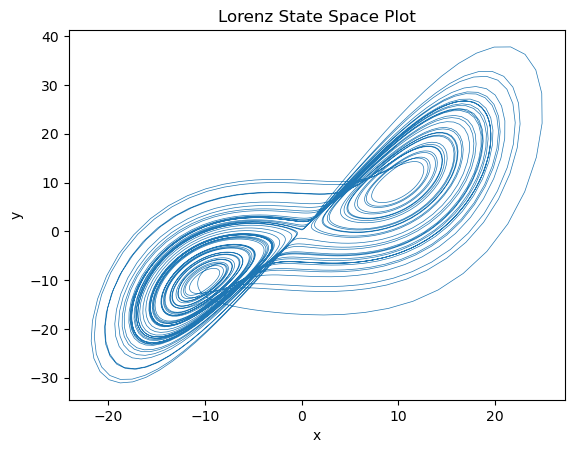

In [25]:
################################################
#
# Plot Results
#

#
# Time Series Plot.
#


Time = Y.t

plt.plot(Time, Y.sol(Time).T[:,0], color="g", linewidth=0.5) # X
plt.plot(Time, Y.sol(Time).T[:,1], color="r", linewidth=0.5) # X
plt.plot(Time, Y.sol(Time).T[:,2], color="b", linewidth=0.5) # X

plt.title("Lorenz Time Series")

plt.xlim(0, TimePeriod)

plt.ylim(np.min(Y.sol(Time).T[:,:]), 
         np.max(Y.sol(Time).T[:,:]))
plt.xlabel('Time (Days)')
plt.ylabel("Populations")
plt.legend(["X", 
            "Y",
            "Z"])
plt.show()


#
# State Space Plots
#

plt.plot(Y.sol(Time).T[:,0], # X
         Y.sol(Time).T[:,1], linewidth=0.5) # Y

plt.title("Lorenz State Space Plot")

plt.xlabel('x')
plt.ylabel("y")

plt.show()

#
################################################

# Wanna get Chaos in 3D?

I normally have issues with 3D lots on 2D frameworks (like a computer screen) but We CAN do this with an "extention" to matplotlib called [mpl_toolkits.mplot3d](https://matplotlib.org/stable/api/toolkits/mplot3d.html?highlight=mpl_toolkits).

Specifically we will use the [mpl_toolkits.mplot3d.axes3d.Axes3D](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.html#mpl_toolkits.mplot3d.axes3d.Axes3D) resource which gives you the keys to the fancier 3D projection.

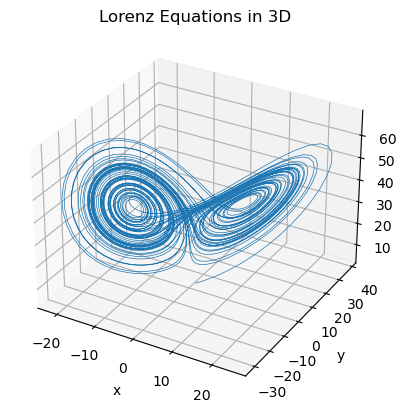

In [22]:
#######################################
#
# Monster Chiller Horror Theatre in 3D
#

fig = plt.figure()
ax  = plt.subplot(projection = '3d')

ax.plot(Y.sol(hirez_time).T[:,0],
        Y.sol(hirez_time).T[:,1],
        Y.sol(hirez_time).T[:,2], linewidth=0.5)
ax.set_ylabel("y")
ax.set_xlabel("x")
ax.set_zlabel("z")

ax.set_title("Lorenz Equations in 3D")


plt.show()

#
#######################################

Much Better!

# Creating an Ensemble of Runs for Different Initial Conditions?

For meteorlogist what makes chaos theory useful is that it can demonstrate the limits of predictability caused by our small nuances in initial conditions.

We can demonstrate that here by running our system in a loop and plotting the resuts.

In [ ]:

fig = plt.figure()
ax  = plt.subplot(projection = '3d')




exes = [0.99, 1, 1.01]
for i in range(len(exes)):
    Y = sciint.solve_ivp(fun    = lorenz, 
                         t_span = [0, End_Time],
                         y0     = [exes[i], 2, 3],
                         method = "RK45",
                         dense_output = True,
                         t_eval   = hirez_time)
    
    ax.plot(Y.sol(hirez_time).T[:,0],
        Y.sol(hirez_time).T[:,1],
        Y.sol(hirez_time).T[:,2])
    
plt.show()                         
    

## Version Information

In [ ]:
################################################################
#
# Loading Version Information
#

%load_ext version_information

%version_information version_information, numpy, scipy, matplotlib

#
################################################################